In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Grid (µm/px)
Nx, Ny = 512, 512
px, py = 0.2, 0.2

# Cylinder geometry
R = 30.0          # radius (µm)
L = 80.0          # axis length along x (µm); set None for infinite

# Optics
lam   = 0.532     # wavelength (µm)
n_med = 1.33      # medium index
pz    = 0.2       # z step for integration (µm)

# Material: either a scalar, a 2D array n(x,y), or a callable n_obj(X,Y,z)
n_obj = 1.38      # try scalar first

Start by defining a shape to test, we'll start by a homogenous cylinder

In [14]:

def make_grid(Nx, Ny, px, py):
    #Centered around 0  
    x = (np.arange(Nx) - Nx/2) * px
    y = (np.arange(Ny) - Ny/2) * py
    return np.meshgrid(x, y, indexing='xy')

def cylinder_phase_perp_to_z_3d(
    Nx, Ny, px, py,           # grid (µm/px)
    R,                        # cylinder radius (µm)
    L,                        # length of cylinder
    lam, n_med,               # wavelength (µm), medium index
    n_obj,                    # scalar, 2D array, or callable n_obj(X,Y,z)
    pz=0.2,                   # z step (µm)
):
    """
    Phase for a cylinder whose axis lies along x (⊥ z), allowing n to depend on z.
    φ(x,y) = (2π/λ) * ∫ [n_obj(x,y,z) - n_med] dz over points inside the circular cross-section.

    n_obj can be: scalar, 3D function
    """
    # Build grid in x,z plane (Ny=Nz now!)
    X, Z = make_grid(Nx, Ny, px, py)  # here Y is "z-axis" in plotting

    # y samples for integration (beam along y)
    y_axis = np.arange(-R, R + 0.5*pz, pz, dtype=float)

    # finite length along z (optional)
    mask_z = (np.abs(Z) <= (L/2.0)).astype(float)

    accum = np.zeros_like(X, dtype=float)
    for y in y_axis:
        mask_xz = ((X**2 + y**2) <= R*R).astype(float)
        mask = mask_xz * mask_z

        if np.isscalar(n_obj):
            dn_slice = (float(n_obj) - n_med) * mask
        else:
            if callable(n_obj):
                try:
                    n_map = np.asarray(n_obj(X, Z, y), dtype=float)
                except TypeError:
                    n_map = np.asarray(n_obj(X, Z), dtype=float)
            else:
                n_map = np.asarray(n_obj, dtype=float)
            if n_map.shape != X.shape:
                raise ValueError("n_obj must produce shape (Ny, Nx).")
            dn_slice = (n_map - n_med) * mask

        accum += dn_slice

    phi_true = (2*np.pi/lam) * accum * pz
    phi_wrapped = np.angle(np.exp(1j*phi_true))
    return phi_true, phi_wrapped

In [15]:
phi_true, phi_wrap = cylinder_phase_perp_to_z_3d(
    Nx, Ny, px, py,
    R, L,
    lam=lam, n_med=n_med,
    n_obj=n_obj,
    pz=pz
)

print("FOV (µm):", Nx*px, "x", Ny*py)
print("Peak phase / π:", float(phi_true.max()/np.pi))

FOV (µm): 102.4 x 102.4
Peak phase / π: 11.315789473684264


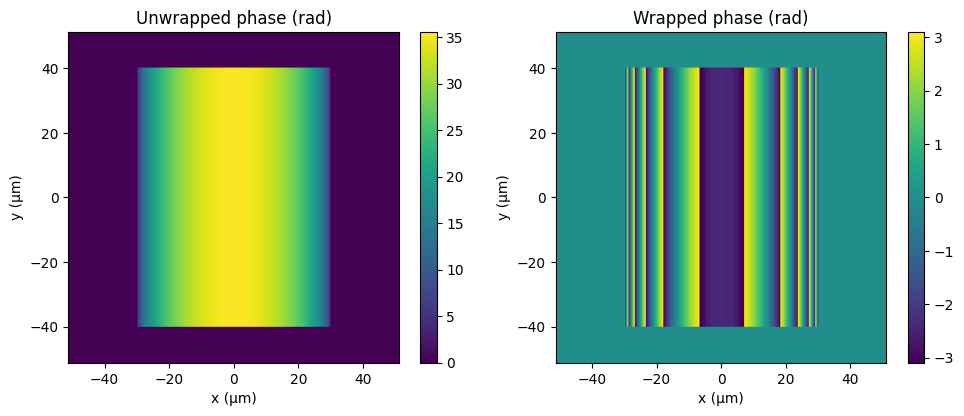

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
im0 = axes[0].imshow(phi_true, origin='lower', extent=[-Nx*px/2, Nx*px/2, -Ny*py/2, Ny*py/2])
axes[0].set_title("Unwrapped phase (rad)"); plt.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(phi_wrap, origin='lower', extent=[-Nx*px/2, Nx*px/2, -Ny*py/2, Ny*py/2])
axes[1].set_title("Wrapped phase (rad)"); plt.colorbar(im1, ax=axes[1])
for ax in axes: ax.set_xlabel("x (µm)"); ax.set_ylabel("y (µm)")
plt.tight_layout()